# AAE 450 Solar Power Mass Simulation
## Noah Stockwell

### Last reviewed 3/31/2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import pandas as pd
import statsmodels.formula.api as smf

In [2]:
sns.set_theme()

## Define Model object
This contains a simple way to call a function with a confidence parameter

In [3]:
class Model:
    def __init__(self, fnctn, confidence):
        self.model = fnctn
        self.confidence = confidence
        
model_list = []

## Model 1: National Space Society

In [4]:
# https://space.nss.org/the-case-for-solar-power-from-space/
# Point estimate 20 kg / kW, assuming 2 sigma 13-25

def nss_model(num_samples):
    norm = sts.norm(loc=19, scale=3)
    return norm.rvs(num_samples)

model_list.append(Model(nss_model, 1))

## Model 2: Boeing 702SP and NASA Power

In [5]:
# https://en.wikipedia.org/wiki/Boeing_702 3kW to 12 kW from 1500kg to 2300kg
# https://www.nasa.gov/smallsat-institute/sst-soa-2020/power mass up to 1/3 of total weight

def b702_model(num_samples):
    sc_mass = sts.norm(loc=1900, scale=130).rvs(num_samples) # assume normal centered at center
    solar_mass = sc_mass * sts.norm(loc=.225, scale=.0275).rvs(num_samples) # 3 sigma normal 15% - 33% mass 
    
    marginal = (3 + 18) / (1500 + 2300) # slope of scale
    sig = (marginal * 1500 - 3) / 3 # 3 sigma to min/max
    sig_rvs = sts.norm().rvs(num_samples)
    sig_rvs[np.abs(sig_rvs) > 3] = 0
    power_delivered = marginal * sc_mass + sig_rvs * sig # all together
    
    return solar_mass / power_delivered

model_list.append(Model(b702_model, 2))

## Model 3: MAVEN and NASA Power

In [6]:
# https://lasp.colorado.edu/home/maven/about/spacecraft/ 1.5kW
# https://www.nasa.gov/smallsat-institute/sst-soa-2020/power mass up to 1/3 of total weight

def maven_model(num_samples):
    sc_mass = 809
    solar_mass = sc_mass * sts.norm(loc=.225, scale=.036).rvs(num_samples) # 3 sigma normal 15% - 33% mass 

    return solar_mass / 1.5

# Doesn't seem to work too well
# model_list.append(Model(maven_model, 2))

## Model 4: UltraFlex

In [7]:
# https://www.jpl.nasa.gov/nmp/st8/tech_papers/2005%20IEEE%20Aerospace%20Conference%20_Big%20Sky_%20Paper-%20NGU%20ST8.pdf
# assuming normal distribution centered at 85 W/kg with 2 sigma at 103 W/kg

def ultraflex_model(num_samples):
    mid = 1e3 * 1 / 85
    high = 1e3 * 1 / 103
    norm = sts.norm(loc=mid, scale=(mid-high) / 2)
    print(mid)
    print((high-mid) / 2)
    return norm.rvs(num_samples)

model_list.append(Model(ultraflex_model, 2))

## Simulate all models

In [8]:
n = 2**8

mod_arr = [x.model(int(n * x.confidence)) for x in model_list]
res = np.hstack(mod_arr)

11.764705882352942
-1.0279840091376364


## Plot the marginal mass

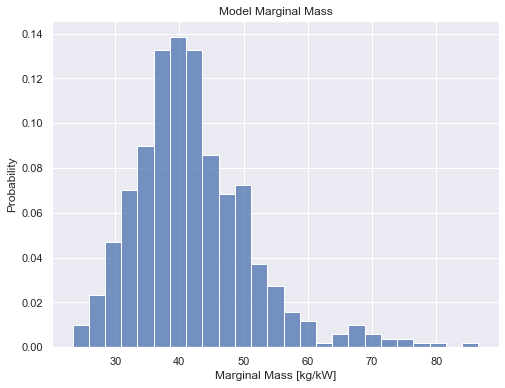

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
sns.histplot(mod_arr[1], stat='probability')
ax.set_xlabel('Marginal Mass [kg/kW]')
ax.set_title("Model Marginal Mass")
fig.savefig('marginal.png', dpi=300)

## Produce linearized model

In [10]:
line_samples = 2 ** 4
x = np.repeat(np.linspace(20, 400, 25), line_samples)

rng = np.random.default_rng()

ms = rng.choice(res, size=x.shape[0], replace=True)
bs = 0

a = .9
top_ms = np.sort(ms)[int(ms.shape[0] * (.5 + a / 2) ** 2)] # $/kW
top_bs = 0

y = bs + x * ms

## Plot linearized model

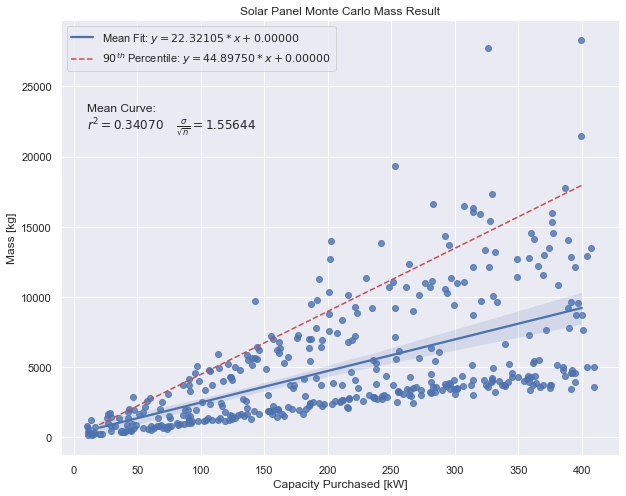

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()
sns.regplot(x=x, y=y, ci=99, x_jitter=10)
ax.set_xlabel('Capacity Purchased [kW]')
ax.set_ylabel('Mass [kg]')
ax.set_title('Solar Panel Monte Carlo Mass Result')
lr = sts.linregress(ax.collections[0].get_offsets().data)
ytxt = np.ptp(ax.get_ylim()) * .75 + ax.get_ylim()[0]
ytxt2 = np.ptp(ax.get_ylim()) * .6 + ax.get_ylim()[0]
plt.text(10, ytxt, f"Mean Curve:\n$r^2={lr.rvalue**2:.5f}$    " + r"$\frac{\sigma}{\sqrt{n}}=$" + f"${lr.stderr:.5f}$")
plt.plot(x, (top_bs + x * top_ms), 'r--')
plt.legend([f'Mean Fit: $y={lr.slope:.5f}*x+{0:.5f}$', 
            f'${100 * a:.0f}^{{th}}$ Percentile: $y={top_ms:.5f}*x+{top_bs:.5f}$'])

fig.savefig('linear_model.png', dpi=300)

## Small plot
Make the same plot as above, just smaller for presentations and stuff

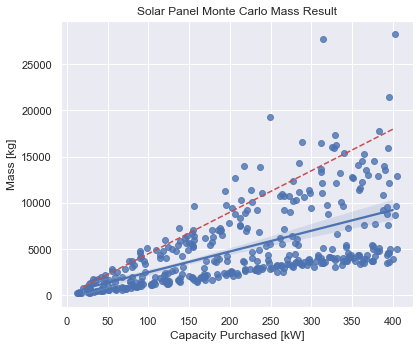

In [12]:
fig = plt.figure(figsize=(6, 5))
ax = plt.gca()
sns.regplot(x=x, y=y, ci=99, x_jitter=10)
ax.set_xlabel('Capacity Purchased [kW]')
ax.set_ylabel('Mass [kg]')
ax.set_title('Solar Panel Monte Carlo Mass Result')
lr = sts.linregress(ax.collections[0].get_offsets().data)
ytxt = np.ptp(ax.get_ylim()) * .75 + ax.get_ylim()[0]
ytxt2 = np.ptp(ax.get_ylim()) * .6 + ax.get_ylim()[0]
# plt.text(10, ytxt, f"Mean Curve:\n$r^2={lr.rvalue**2:.5f}$    " + r"$\frac{\sigma}{\sqrt{n}}=$" + f"${lr.stderr:.5f}$")
plt.plot(x, (top_bs + x * top_ms), 'r--')

fig.tight_layout()

fig.savefig('linear_model_small.png', dpi=300)

In [13]:
stats_table = pd.DataFrame(data=np.vstack([x, y]).T, columns=['Power', 'Mass'])